# 2––Forecasting

* Univariate
* Univariate with exogenous variables 
* Multivariate

In [1]:
from warnings import simplefilter

simplefilter(action="ignore", category=RuntimeWarning)

---
## Univariate forecasting

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.

<img src="../images/forecasting.png" width=1000/>


### The basic workflow

1. Specify data
1. Specify task
1. Specify model
1. Fit
1. Predict

#### Data

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

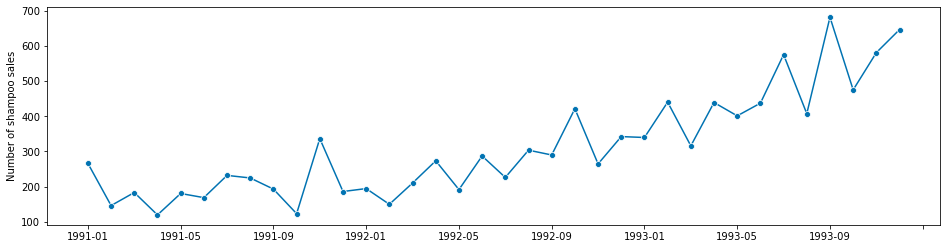

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

plot_series(y)

#### Task specification


Next we will define a forecasting task.

* We will try to predict the last 6 months of data, using the previous data as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the MAPE (mean absolute percentage error) to quantify the accuracy of our forecasts. A lower MAPE means higher accuracy.

#### The forecasting horizon

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm. We can specify the forecasting horizon as a numpy array of the steps ahead relative to the end of the training series:

**Using an array of values**

In [3]:
import numpy as np

fh = np.arange(6) + 1
fh

array([1, 2, 3, 4, 5, 6])

**Using the ForecastingHorizon object**

In [4]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(
    pd.period_range("1993-07", periods=6, freq="M"), is_relative=False
)
fh

ForecastingHorizon(['1993-07', '1993-08', '1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]', is_relative=False)

In [5]:
cutoff = pd.Period("1993-06", freq="M")
fh.to_relative(cutoff)

ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True)

#### Train-test split

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

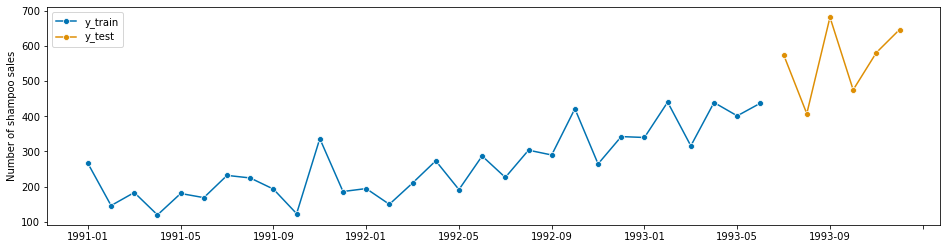

In [7]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])

#### Model specification

In [8]:
from sktime.forecasting.naive import NaiveForecaster

In [9]:
forecaster = NaiveForecaster(strategy="drift", window_length=10)

#### Fitting

In [10]:
forecaster.fit(y_train)

NaiveForecaster(strategy='drift', window_length=10)

In [11]:
forecaster.fit?

Signature: forecaster.fit(y, X=None, fh=None)
Docstring:
Fit forecaster to training data.

State change:
    Changes state to "fitted".

Writes to self:
    Sets self._is_fitted flag to True.
    Writes self._y and self._X with `y` and `X`, respectively.
    Sets self.cutoff and self._cutoff to last index seen in `y`.
    Sets fitted model attributes ending in "_".
    Stores fh to self.fh if fh is passed.

Parameters
----------
y : pd.Series, pd.DataFrame, or np.ndarray (1D or 2D)
    Time series to which to fit the forecaster.
    if self.get_tag("scitype:y")=="univariate":
        must have a single column/variable
    if self.get_tag("scitype:y")=="multivariate":
        must have 2 or more columns
    if self.get_tag("scitype:y")=="both": no restrictions apply
fh : int, list, np.array or ForecastingHorizon, optional (default=None)
    The forecasters horizon with the steps ahead to to predict.
    if self.get_tag("requires-fh-in-fit"), must be passed, not optional
X : pd.DataFrame

#### Prediction

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

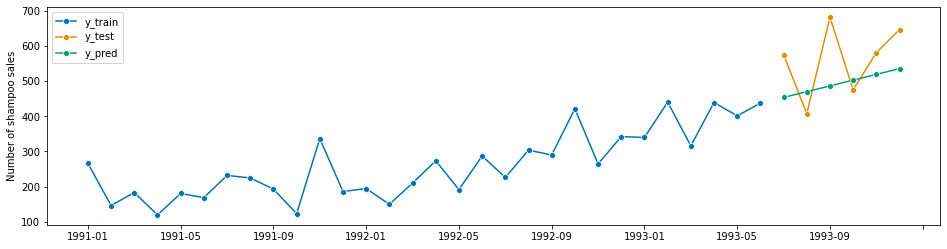

In [12]:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

#### Evaluation

In [13]:
from sktime.performance_metrics.forecasting import \
    mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.16469764622516225

#### Another example

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

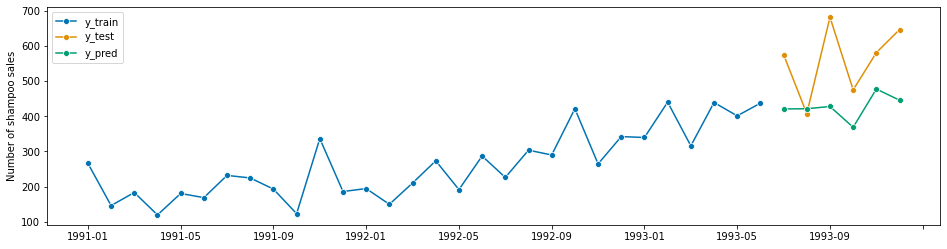

In [14]:
from sktime.forecasting.arima import AutoARIMA

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y, fh=fh)
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

### Summary of basic workflow
* single, fixed cutoff point at which we generate predictions
* common interface for forecasters

### Forecasters in sktime

Check out our online estimator overview at: https://www.sktime.org/en/stable/estimator_overview.html

In [15]:
from sktime.registry import all_estimators

In [16]:
all_estimators("forecaster", as_dataframe=True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'fbprophet'. 'fbprophet' is a soft dependency and not included in the sktime installation. Please run: `pip install fbprophet`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'tbats'. 'tbats' is a soft dependency and not included in the sktime installation. Please run: `pip install tbats`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)


,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
5,Croston,<class 'sktime.forecasting.croston.Croston'>
6,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
7,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
8,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
9,DirectTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


### But can I not just use scikit-learn?

In principle, yes, but many pitfalls ...

See our previous tutorial from the PyData Amsterdam 2020 for more details: https://github.com/sktime/sktime-tutorial-pydata-amsterdam-2020
 
**Better: Use scikit-learn with sktime!**

sktime provides a meta-estimator for this approach, which is: 
* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **parametric** and **tuneable**, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

<img src="../images/forecasting-to-regression-reduction.png" width=500 align=right />


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

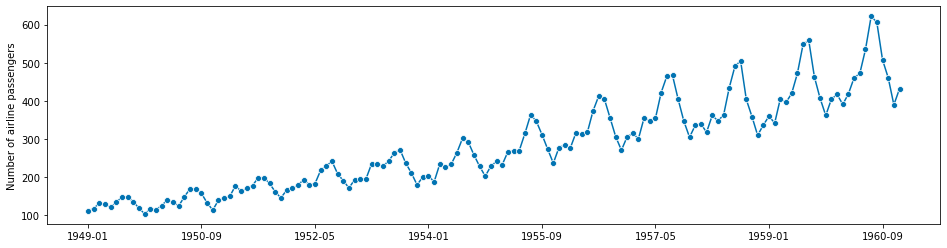

In [17]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

In [18]:
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

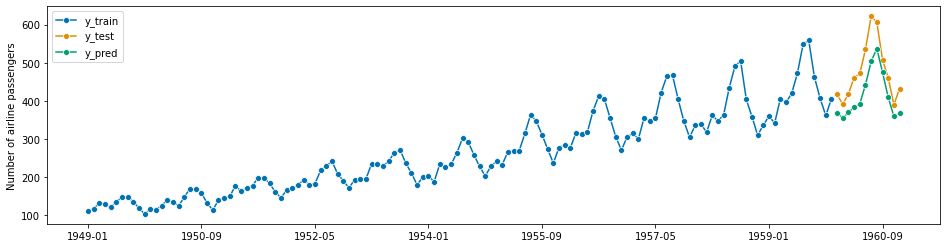

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy="recursive", window_length=12)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

---
### The more advanced workflow

1. Specify data
1. Specify task
1. Specify model
1. Fit
1. Predict
1. Observe new data
1. Update using new data
1. Repeat steps 5-7 as often as required

#### Data specification

In [20]:
from sktime.forecasting.ets import AutoETS

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

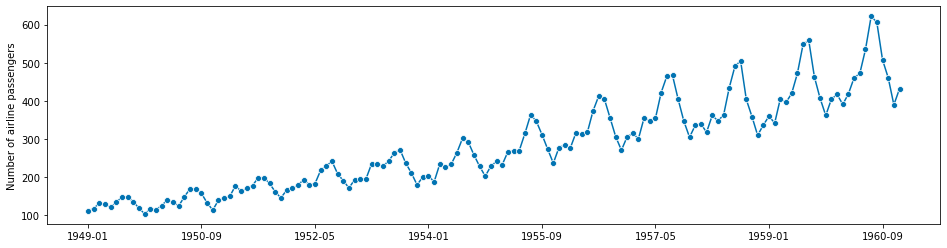

In [21]:
# specifying the data
y = load_airline()
plot_series(y)

#### Task specification

In [22]:
# specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
#  in December 1975
# this is the data known in December 1975
y_train = y.loc[:"1957-08"]
y_observed = y_train.copy()
y_observed.tail()

1957-04    348.0
1957-05    355.0
1957-06    422.0
1957-07    465.0
1957-08    467.0
Freq: M, Name: Number of airline passengers, dtype: float64

#### Model specification

In [24]:
# specifying the model
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

#### Fitting

In [25]:
# fit
forecaster.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

#### Prediction

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

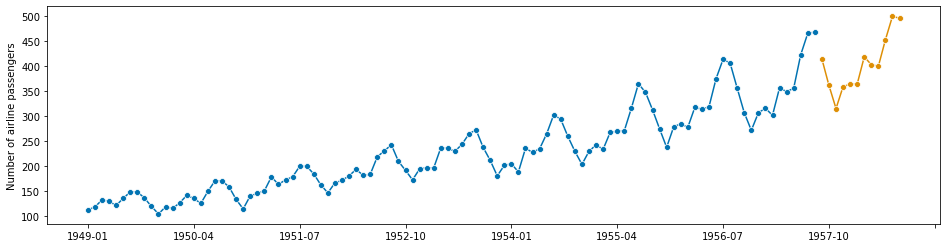

In [26]:
# predict for Jan 1958 - Dec 1958
y_pred = forecaster.predict(fh)
plot_series(y_observed, y_pred)

#### Observe new data

In [27]:
y_observed = y.loc[:"1957-09"]
new_data = y.loc[["1957-09"]]
new_data

1957-09    404.0
Freq: M, Name: Number of airline passengers, dtype: float64

#### Update

In [28]:
forecaster.update(new_data)

/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:1097: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called.
  warn(


AutoETS(auto=True, n_jobs=-1, sp=12)

#### Predict again

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

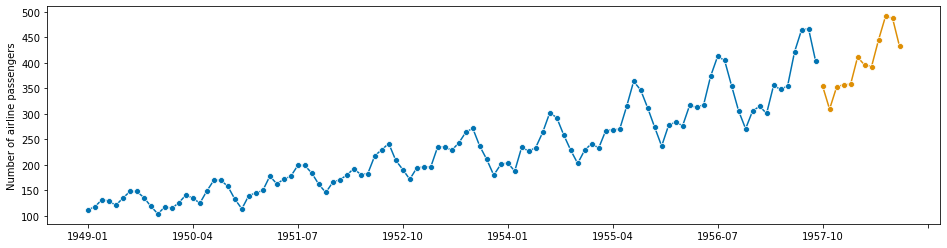

In [29]:
y_pred = forecaster.predict(fh)
plot_series(y_observed, y_pred)

#### Understanding update


In [30]:
forecaster.update?

Signature: forecaster.update(y, X=None, update_params=True)
Docstring:
Update cutoff value and, optionally, fitted parameters.

If no estimator-specific update method has been implemented,
default fall-back is as follows:
    update_params=True: fitting to all observed data so far
    update_params=False: updates cutoff and remembers data only

State required:
    Requires state to be "fitted".

Accesses in self:
    Fitted model attributes ending in "_".
    Pointers to seen data, self._y and self.X
    self.cutoff, self._is_fitted
    If update_params=True, model attributes ending in "_".

Writes to self:
    Update self._y and self._X with `y` and `X`, by appending rows.
    Updates self. cutoff and self._cutoff to last index seen in `y`.
    If update_params=True,
        updates fitted model attributes ending in "_".

Parameters
----------
y : pd.Series, pd.DataFrame, or np.ndarray (1D or 2D)
    Time series to which to fit the forecaster.
    if self.get_tag("scitype:y")=="univar

### Automating the process

In [31]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from utils import plot_windows

In [32]:
y = load_airline()
fh = ForecastingHorizon(np.arange(12) + 1)
y_train, y_test = temporal_train_test_split(y, fh=fh)

#### Temporal cross-validation

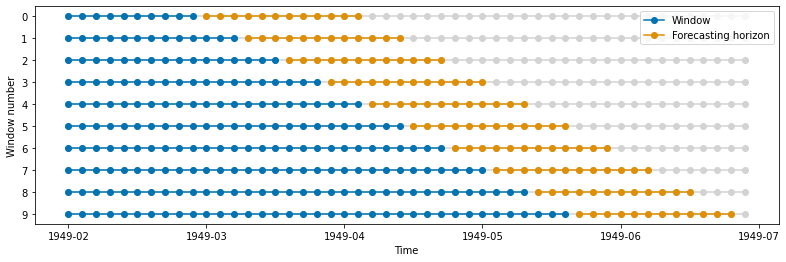

In [33]:
cv = ExpandingWindowSplitter(step_length=3, fh=fh, initial_window=10)
plot_windows(cv, y.iloc[:50])

Check out alternative cross-validation schemes: https://github.com/alan-turing-institute/sktime/blob/main/examples/window_splitters.ipynb

#### Backtesting: Evaluation using temporal cross-validaton

In [34]:
forecaster = NaiveForecaster(strategy="last", sp=12)
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=72)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True
)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.172282,0.001779,0.003692,72,1954-12
1,0.144885,0.002645,0.003558,84,1955-12
2,0.113814,0.002512,0.003494,96,1956-12
3,0.032201,0.002507,0.003410,108,1957-12
4,0.117614,0.002511,0.003408,120,1958-12


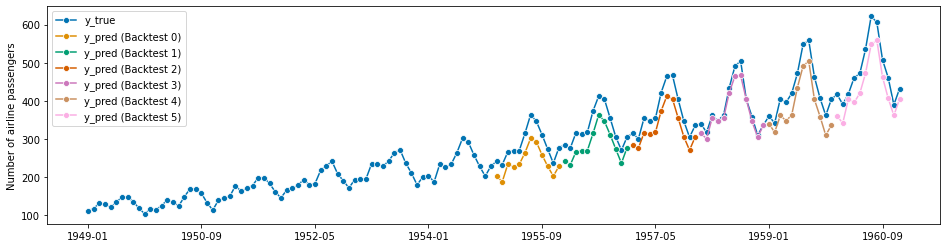

In [35]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[0],
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    results["y_pred"].iloc[3],
    results["y_pred"].iloc[4],
    results["y_pred"].iloc[5],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

### Advanced model building & composition

#### Tuning

In [36]:
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)

param_grid = {"window_length": [9, 12, 15], "estimator__n_neighbors": np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(window_length=60, fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, strategy="refit"
)

0.11457793874841497

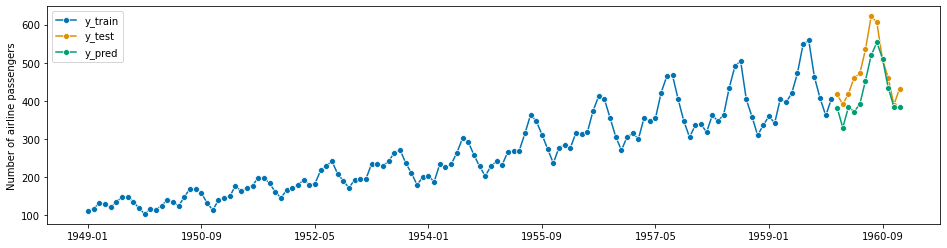

In [37]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [38]:
gscv.best_params_

{'estimator__n_neighbors': 2, 'window_length': 12}

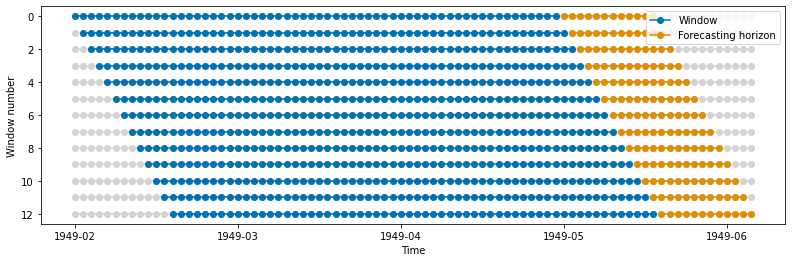

In [39]:
plot_windows(cv, y.iloc[:84])

#### Tuning and AutoML 

In [40]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
gscv.best_params_

{'selected_forecaster': 'ets'}

#### Pipelining

In [41]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [42]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=12)),
        ("detrend", Detrender()),
        ("forecast", forecaster),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

---
## Univariate forecasting with exogenous variables
* a single target (or endogeneous) series, observed only in the past 
* one ore more related (exogeneous) time series, observed in the past and period of forecasting horizon

### Basic workflow

In [43]:
from sktime.datasets import load_longley

In [44]:
y, X = load_longley()

In [45]:
y.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [46]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [47]:
fh = np.arange(5) + 1
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='TOTEMP'>)

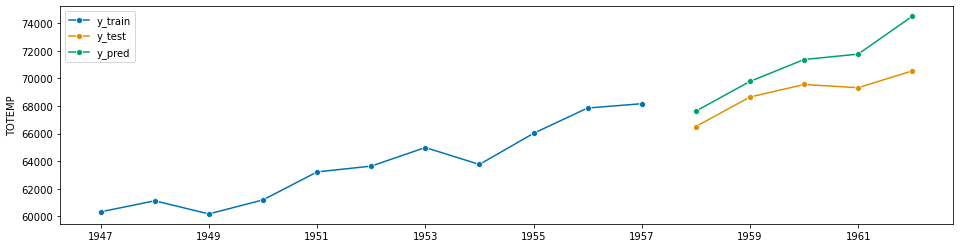

In [48]:
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_pred)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

### Pipelining with exogenous data

In [49]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sktime.datasets import load_macroeconomic
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer

In [50]:
data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

In [51]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)
fh = ForecastingHorizon(y_test.index, is_relative=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='unemp'>)

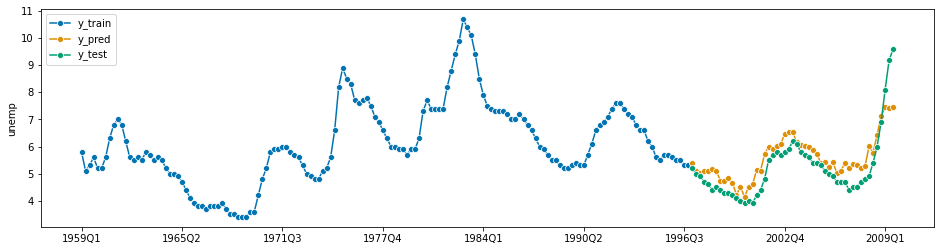

In [52]:
forecaster = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("scale", TabularToSeriesAdaptor(MinMaxScaler(feature_range=(1, 2)))),
        ("boxcox", TabularToSeriesAdaptor(PowerTransformer(method="box-cox"))),
        ("forecaster", AutoARIMA(suppress_warnings=True)),
    ]
)
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

plot_series(y_train, y_pred, y_test, labels=["y_train", "y_pred", "y_test"])

---
## Multivariate forecasting
* multiple target series

In [53]:
all_estimators(
    "forecaster",
    filter_tags={"scitype:y": ["both", "multivariate"]},
    return_names=False,
)

/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'fbprophet'. 'fbprophet' is a soft dependency and not included in the sktime installation. Please run: `pip install fbprophet`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'tbats'. 'tbats' is a soft dependency and not included in the sktime installation. Please run: `pip install tbats`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)


[sktime.forecasting.compose._column_ensemble.ColumnEnsembleForecaster,
 sktime.forecasting.model_selection._tune.ForecastingGridSearchCV,
 sktime.forecasting.compose._pipeline.ForecastingPipeline,
 sktime.forecasting.model_selection._tune.ForecastingRandomizedSearchCV,
 sktime.forecasting.compose._multiplexer.MultiplexForecaster,
 sktime.forecasting.naive.NaiveForecaster,
 sktime.forecasting.compose._pipeline.TransformedTargetForecaster,
 sktime.forecasting.var.VAR]

In [54]:
_, y = load_longley()
y = y.iloc[:, 2:4]

fh = np.arange(3) + 1
y_train, y_test = temporal_train_test_split(y, fh=fh)

### By-variable ensembling

In [55]:
from sktime.forecasting.compose import ColumnEnsembleForecaster

forecasters = [
    ("trend", PolynomialTrendForecaster(), 0),
    ("ses", ExponentialSmoothing(), 1),
]
forecaster = ColumnEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
y_pred.head()

,UNEMP,ARMED
1960,3688.653846,2552.429032
1961,3794.186813,2552.429032
1962,3899.719780,2552.429032


### Bespoke multivariate models

In [56]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
y_pred.head()

,UNEMP,ARMED
1960,3322.412772,2611.267028
1961,3153.426497,2673.109450
1962,3095.843989,2725.059253


/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


---
## Building your own forecaster

Check out our [forecasting extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/forecasting.py)!

This is a Python file with to-do code blocks that allow you to implement your own, sktime-compatible forecasting algorithm.


---
## Summary

* unified API for univariate & multivariate forecasting 
* integrating other packages (e.g. scikit-learn, statsmodels, pmdarima, prophet)
* composite model building (pipelining, ensembling, tuning, reduction)
* easily extendible

#### Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).
